# Project 1 TAA

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to load matlab mat files
from scipy.io import loadmat

In [21]:
mat=loadmat("training_data_happy_sad.mat")

# mat is a dict with key "X" for x-values, and key "y" for y values
X=mat["X"]
y=mat["y"]

#number of training examples
m = len(X)
print(f"Loaded {X.shape[0]} traing examples, each with {X.shape[1]} features (pixels).")

Loaded 2000 traing examples, each with 2304 features (pixels).


### sigmoid function

In [22]:
# Add sigmoid FUNCTION from the previous lab
def sigmoid(z):
    """
    return the sigmoid of z
    """
    gz=1/(1+np.exp(-z))
    
    return gz

In [23]:
#Computes the gradient of sigmoid function
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid) 

### neural network cost function

In [61]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network (regularized and non regularized)
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_cost = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_cost, grad1_reg, grad2_reg

In [62]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels,regularized=False):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2, reg_cost, grad1_reg, grad2_reg = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)
        if regularized:
            cost, grad1, grad2 = reg_cost, grad1_reg, grad2_reg
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [63]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [64]:
input_layer_size  = X.shape[1]
hidden_layer_size = 100
num_labels = 2

In [97]:
# Define algorithm properties
alpha=1 #learning rate
num_iters=1000
Lambda=0.1

In [ ]:
# Initialize thetas
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

# Gradient descent WITHOUT regularization
nnTheta, nnJ_history = gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels)
Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

# Gradient descent WITH regularization
nnTheta_reg, nnJ_history_reg = gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels, regularized=True)
Theta1_reg = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2_reg = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

### Analysys (Cost function by iterations)

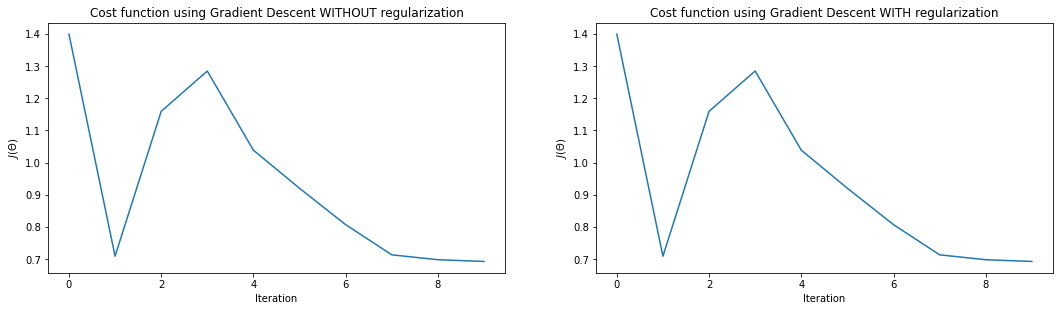

In [93]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(nnJ_history)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("$J(\Theta)$")
axs[0].set_title("Cost function using Gradient Descent WITHOUT regularization")

axs[1].plot(nnJ_history_reg)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("$J(\Theta)$")
axs[1].set_title("Cost function using Gradient Descent WITH regularization")

fig.set_size_inches(18, 4.6)

### Compute accuracy

In [94]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
    
    #number of training examples
    m=X.shape[0]
        
    # add an extra column of 1´s corresponding to xo=1
    X = np.append(np.ones((m,1)), X,axis=1)
    
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1= np.dot(X,Theta1.T)
    a1= sigmoid(z1)
    
    #Add a column of ones
    a1 = np.append(np.ones((m,1)), a1,axis=1)
    
    #Compute the output of the output layer (with sigmoid activation functions)
    z2= np.dot(a1,Theta2.T)
    a2= sigmoid(z2)
    
    return np.argmax(a2,axis=1)+1

In [95]:
pred2 = predict(Theta1, Theta2, X)
print("Training Set Accuracy:",sum(pred2[:,np.newaxis]==y)[0]/m*100,"%")

Training Set Accuracy: 50.0 %
